## Iris dataset: fastai.tabular vs xgboost
In this workbook, I am doing a simple test with a simple demo dataset (the iris dataset from scikit-learn) to examine the effectiveness of fastai vs xgboost.
In hindsight, this dataset is too simple to really tease out differences, but at least it shows how each can be used.

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from fastai.tabular import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

In [2]:
# Load the demo iris dataset
iris = load_iris()

# np.c_ is the numpy concatenate function
# which is used to concat iris['data'] and iris['target'] arrays 
# for pandas column argument: concat iris['feature_names'] list
# and string list (in this case one string)
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['species'])

In [3]:
# quick look at the data
data1.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


# XGBOOST GPU

In [4]:
X = iris['data']

In [5]:
Y = iris['target']

In [6]:
# split data into train and test sets
seed = 4
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [7]:
params = { "n_estimators": 1000, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}

In [8]:
model = XGBClassifier(**params)

In [9]:
%%time
model.fit(X_train, y_train)

CPU times: user 5.37 s, sys: 1.66 s, total: 7.03 s
Wall time: 7.04 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method='gpu_hist', verbosity=1)

In [10]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [11]:
# evaluate predictions
acc_sc = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (acc_sc * 100.0))

Accuracy: 97.37%


# FASTAI

In [12]:
# None of the features are categorical, they are all continuous variables
dep_var = 'species'
continuous_feature_names = iris['feature_names']
procs = [Categorify, Normalize]

In [13]:
# I made the target names strings, even though they have been converted to numbers in the iris data,
# just because the fastai tabularlist can handle the categorification process itself, and leaving doubles in there
# caused an error with pytorch wanting to see floats.
data1['species'] = data1['species'].astype(str)

In [14]:
data = (TabularList.from_df(data1, cont_names=continuous_feature_names, procs=procs)
                           .split_by_rand_pct(valid_pct=0.25, seed=4)
                           .label_from_df(cols=dep_var)
                           .databunch())

In [15]:
learn = tabular_learner(data, layers=[400,200], metrics=accuracy)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


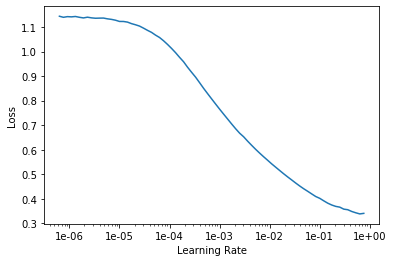

In [17]:
learn.recorder.plot()

In [18]:
learn.fit(15, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.112715,0.778505,0.891892,00:00
1,0.672102,0.569310,0.891892,00:00
2,0.472428,0.444100,0.891892,00:00
3,0.383166,0.362083,0.864865,00:00
4,0.326860,0.310641,0.864865,00:00
5,0.281272,0.279981,0.864865,00:00
6,0.246619,0.258528,0.864865,00:00
7,0.224284,0.242800,0.864865,00:00
8,0.203064,0.227213,0.864865,00:00
9,0.186614,0.215070,0.864865,00:00


# Thoughts
I managed to get the same accuracy with fastai tabular as I did with xgboost, but it took more fiddling. I tihnk I need to find a bigger dataset to test this, the iris dataset doesn't give much scope, with individiual errors greatly impacting the final scoring.